# **Investment Portfolio Tracker**

In [117]:
import yfinance as yf
import pandas as pd
from datetime import datetime

In [118]:
df_transaction = pd.read_excel('/Users/caitlynkay/Desktop/TransactionHistory.xlsx')
df_transaction.set_index('DATE', inplace=True)

first_purchase = df_transaction.index[0]
df_transaction

,TICKER,ACTION,QTY,PRICE,FEE,TOTAL
DATE,,,,,,
2024-02-01,AMZN,BUY,1.00,156.51,0.47,156.9800
2024-02-01,SHEL,BUY,2.00,64.25,0.38,128.8800
2024-02-02,GOOG,BUY,1.00,142.81,0.43,143.2400
2024-02-12,NVDA,BUY,0.25,737.57,0.57,184.9625
2024-02-13,NVDA,BUY,0.25,721.37,0.56,180.9025
2024-02-13,FVRR,BUY,3.00,30.62,0.29,92.1500
2024-03-12,MSTR,BUY,0.20,1449.00,0.35,290.1500
2024-03-18,MSTR,BUY,0.30,1450.00,0.35,435.3500
2024-03-20,MSTR,SELL,0.50,1500.00,0.36,749.6400


In [119]:
ticker_list = set(df_transaction['TICKER'])
split_list = []
for key in ticker_list:
    stock = yf.Ticker(key)
    splits = stock.get_splits()
    split_list.append(splits)

In [120]:
# Stock splits after first purchase date

df_split = pd.concat(split_list, keys=ticker_list)
df_split = df_split.to_frame()
df_split = df_split.reset_index(level=0, names='Ticker')
df_split = df_split.sort_index()
df_split.index = df_split.index.tz_localize(None)
df_split = df_split[df_split.index > first_purchase]
df_split

,Ticker,Stock Splits
Date,,
2024-06-10,NVDA,10.0
2024-08-08,MSTR,10.0


## **Transaction History Adjusted for Stock Splits**

In [121]:
for datesplit, dsrow in df_split.iterrows():
    condition = (df_transaction.index < datesplit) & (df_transaction['TICKER'] == dsrow['Ticker'])
    df_transaction.loc[condition, 'QTY'] *= dsrow['Stock Splits']
    df_transaction.loc[condition, 'PRICE'] /= dsrow['Stock Splits']

buycond = df_transaction['ACTION'] == 'BUY'
df_transaction.loc[buycond, 'PRICE'] += df_transaction.loc[buycond, 'FEE']/df_transaction.loc[buycond, 'QTY']
sellcond = df_transaction['ACTION'] == 'SELL'
df_transaction.loc[sellcond, 'PRICE'] -= df_transaction.loc[sellcond, 'FEE']/df_transaction.loc[sellcond, 'QTY']

df_transaction = df_transaction.drop(columns='FEE')
df_transaction

,TICKER,ACTION,QTY,PRICE,TOTAL
DATE,,,,,
2024-02-01,AMZN,BUY,1.0,156.980000,156.9800
2024-02-01,SHEL,BUY,2.0,64.440000,128.8800
2024-02-02,GOOG,BUY,1.0,143.240000,143.2400
2024-02-12,NVDA,BUY,2.5,73.985000,184.9625
2024-02-13,NVDA,BUY,2.5,72.361000,180.9025
2024-02-13,FVRR,BUY,3.0,30.716667,92.1500
2024-03-12,MSTR,BUY,2.0,145.075000,290.1500
2024-03-18,MSTR,BUY,3.0,145.116667,435.3500
2024-03-20,MSTR,SELL,5.0,149.928000,749.6400


In [122]:
stock_qty = df_transaction['ACTION'].map({'BUY': 1, 'SELL': -1}).mul(df_transaction['QTY']).groupby(df_transaction['TICKER']).sum().to_dict()

keys_to_remove = [key for key in stock_qty if stock_qty[key] == 0]
for key in keys_to_remove:
    del stock_qty[key]

stock_qty

{'AMZN': 3.0, 'FVRR': 3.0, 'GOOG': 1.0, 'NVDA': 7.0, 'SHEL': 2.0}

In [123]:
sold_stocks = [] # List of stocks that have been sold at least once

for i, transaction in df_transaction.iterrows():
    if transaction['ACTION'] == 'SELL':
        sold_stocks.append(transaction['TICKER'])

sold_stocks = list(dict.fromkeys(sold_stocks)) # remove duplicates

In [124]:
buy_price, buy_qty, sell_price, sell_qty = ([] for i in range(4))
average_price = dict.fromkeys(sold_stocks)
realized_profit = dict.fromkeys(sold_stocks)

for stks in sold_stocks:
    for i, transaction in df_transaction.iterrows():
        if transaction['TICKER'] == stks:
            if transaction['ACTION'] == 'BUY':
                buy_qty.append(transaction['QTY'])
                buy_price.append(transaction['PRICE'])
            if transaction['ACTION'] == 'SELL':
                sell_qty.append(transaction['QTY'])
                sell_price.append(transaction['PRICE'])

    s, b, profit, totalprofit = (0 for i in range(4))

    while s < len(sell_qty) and b < len(buy_qty):
        if sell_qty[s] - buy_qty[b] > 0:
            profit = buy_qty[b]*sell_price[s] - buy_qty[b]*buy_price[b]
            totalprofit += profit
            sell_qty[s] -= buy_qty[b]
            buy_qty[b] = 0
            b += 1
        elif sell_qty[s] - buy_qty[b] == 0:
            profit = buy_qty[b]*sell_price[s] - buy_qty[b]*buy_price[b]
            totalprofit += profit
            sell_qty[s] -= buy_qty[b]
            buy_qty[b] = 0
            s += 1
            b += 1
        elif sell_qty[s] - buy_qty[b] < 0:
            profit = sell_qty[s]*sell_price[s] - sell_qty[s]*buy_price[b]
            totalprofit += profit
            buy_qty[b] -= sell_qty[s]
            sell_qty[s] = 0
            s += 1

    realized_profit.update({stks: totalprofit})

    qty, total, avgprice = (0 for i in range(3))

    for b in range(0, len(buy_qty)):
        qty += buy_qty[b]
        if buy_qty[b] == 0:
            total = 0
        if buy_qty[b] != 0:
            total += buy_qty[b]*buy_price[b]
            avgprice = total/qty

    average_price.update({stks: avgprice})

average_price, realized_profit

({'MSTR': 0}, {'MSTR': 308.5479999999999})

## **Average Stock Price**
#### Total purchase amount divided by the number of shares purchased

In [125]:
df_buy = df_transaction[df_transaction['ACTION'] == 'BUY']
total_owned = df_buy.groupby('TICKER')['TOTAL'].sum()
df_average_price = total_owned / df_buy.groupby('TICKER')['QTY'].sum()
df_average_price = df_average_price.to_frame('AVG PRICE')
df_average_price['AVG PRICE'].update(average_price)
df_average_price = df_average_price.loc[(df_average_price != 0).any(axis=1)]
df_average_price

,AVG PRICE
TICKER,
AMZN,157.686667
FVRR,30.716667
GOOG,143.240000
NVDA,78.602143
SHEL,64.440000


## **Realized Profit**
#### FIFO cost basis method

In [126]:
pd.DataFrame.from_dict(realized_profit, orient='index', columns=['REALIZED GAIN (LOSS)'])

,REALIZED GAIN (LOSS)
MSTR,308.548


In [127]:
def getStockIndustry(ticker):
    stock = yf.Ticker(ticker)
    if (stock.info['quoteType'] == 'EQUITY'):
        stock_industry = stock.info['industry']
    else:
        stock_industry = stock.info['quoteType']
    return stock_industry

def getCurrentPrice(ticker):
    stock = yf.Ticker(ticker)
    if (stock.info['quoteType'] == 'EQUITY'):
        current_price = stock.info['currentPrice']
    else:
        current_price = stock.info['previousClose']
    return current_price

def getPreviousClosePrice(ticker):
    stock = yf.Ticker(ticker)
    previous_close = stock.info['previousClose']
    return previous_close

def getStockValue(ticker, quantity):
    stock_value = getCurrentPrice(ticker) * quantity
    return stock_value

def getPortfolioValue():
    total_value = sum(getStockValue(ticker, stock_qty[ticker]) for ticker in stock_qty)
    return total_value

def getStockPercentage(ticker, quantity):
    stock_value = getStockValue(ticker, quantity)
    percentage = stock_value/getPortfolioValue()*100
    return percentage

def getStockYearHighLow(ticker, value):
    stock = yf.Ticker(ticker)
    if value == 'high':
        year_value = stock.info['fiftyTwoWeekHigh']
    if value == 'low':
        year_value = stock.info['fiftyTwoWeekLow']
    return year_value

def getStockGainLoss(ticker):
    gainloss = getStockValue(ticker, stock_qty[ticker]) - df_average_price.at[ticker, 'AVG PRICE']*stock_qty[ticker]
    return gainloss

In [128]:
portfolio_dict = {'TICKER': [], 'INDUSTRY': [], 'PRICE': [], 'QTY': [],  'TOTAL': [], 'PERCENTAGE': [], 'DAY Δ': [], '52W HIGH': [], '52W LOW': [], 'GAIN (LOSS)': []}
for ticker in stock_qty:
    stock_industry = getStockIndustry(ticker)
    stock_price = getCurrentPrice(ticker)
    stock_value = getStockValue(ticker, stock_qty[ticker])
    percentage = getStockPercentage(ticker, stock_qty[ticker])
    day_change = stock_price-getPreviousClosePrice(ticker)
    year_high = getStockYearHighLow(ticker, 'high')
    year_low = getStockYearHighLow(ticker, 'low')
    stock_gainloss = getStockGainLoss(ticker)
        
    # Append stock information into portfolio_dict
    portfolio_dict['TICKER'].append(ticker)
    portfolio_dict['INDUSTRY'].append(stock_industry)
    portfolio_dict['PRICE'].append(stock_price)
    portfolio_dict['QTY'].append(stock_qty[ticker])
    portfolio_dict['TOTAL'].append(stock_value)
    portfolio_dict['PERCENTAGE'].append(percentage)
    portfolio_dict['DAY Δ'].append(day_change)
    portfolio_dict['52W HIGH'].append(year_high)
    portfolio_dict['52W LOW'].append(year_low)
    portfolio_dict['GAIN (LOSS)'].append(stock_gainloss)

## **Portfolio Summary**

In [129]:
df_portfolio = pd.DataFrame(data=portfolio_dict).sort_values(by='TOTAL', ascending=False)
df_portfolio.set_index('TICKER', inplace=True)
df_portfolio

,INDUSTRY,PRICE,QTY,TOTAL,PERCENTAGE,DAY Δ,52W HIGH,52W LOW,GAIN (LOSS)
TICKER,,,,,,,,,
NVDA,Semiconductors,121.40,7.0,849.80,47.486002,-2.64,140.760,39.230,299.585
AMZN,Internet Retail,187.97,3.0,563.91,31.510746,-3.19,201.200,118.350,90.850
GOOG,Internet Content & Information,165.29,1.0,165.29,9.236245,1.46,193.310,121.460,22.050
SHEL,Oil & Gas Integrated,66.11,2.0,132.22,7.388326,0.77,74.605,60.337,3.340
FVRR,Internet Content & Information,26.12,3.0,78.36,4.378681,0.76,31.610,18.830,-13.790


Total portfolio value: 1789.58
as of 2024-09-28 22:25:48.115598


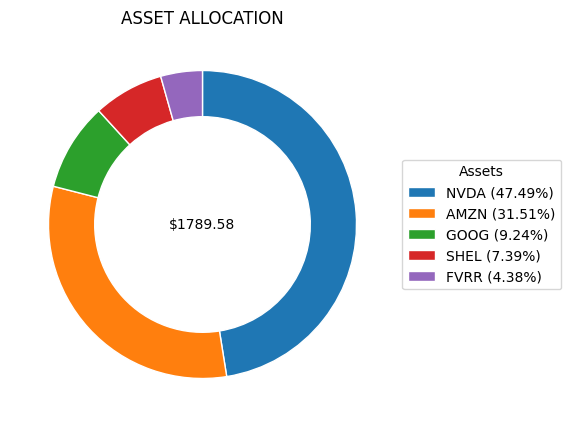

In [130]:
portfolio_value = getPortfolioValue()

plot = df_portfolio.plot.pie(y='PERCENTAGE',
                            title='ASSET ALLOCATION',
                            figsize=(5, 5),
                            legend=False,
                            wedgeprops=dict(width=0.3, edgecolor='w'),
                            startangle=90,
                            counterclock=False,
                            labels=None)

legend = [f'{idx} ({value:.2f}%)' for idx, value in zip(df_portfolio.index, df_portfolio['PERCENTAGE'].values)]

plot.legend(title='Assets',
            loc='center left',
            bbox_to_anchor=(1, 0, 0, 1),
            labels=legend)
plot.set_ylabel(ylabel=None)
plot.text(0, 0, f'${portfolio_value:.2f}', va = 'center', ha = 'center')

print(f'Total portfolio value: {portfolio_value:.2f}')
print(f'as of {datetime.now()}')

Total unrealized gain/loss: 402.03 (28.97%)


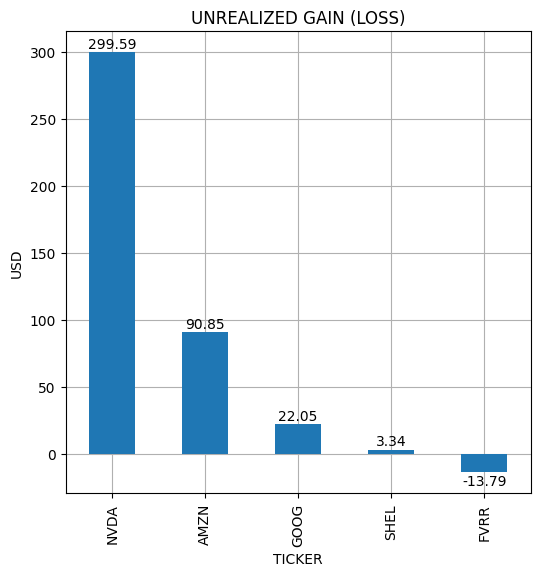

In [131]:
plot = df_portfolio.plot.bar(y='GAIN (LOSS)',
                            title='UNREALIZED GAIN (LOSS)',
                            figsize=(6, 6),
                            zorder=2,
                            legend=False)
plot.bar_label(plot.containers[0],
               fmt='%.2f',
               padding=1)
plot.set_ylabel('USD')
plot.grid(zorder=0)

gainloss = sum(df_portfolio['GAIN (LOSS)'].values)
percentgain = gainloss/(portfolio_value-gainloss)*100
print(f'Total unrealized gain/loss: {gainloss:.2f} ({percentgain:.2f}%)')
